 This notebook picks a bunch of healpix pixels,and places a mock cluster at the center of each

And adds shear to background objects

In [52]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp
import images

import multiprocessing as mp

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.render.icl as icl


In [2]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [3]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

# This is the field

In [4]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])

In [5]:
pixel_id = 0

In [6]:
alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

In [7]:
pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

In [8]:
def make_mock(table, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    pixel_scale = 0.264
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"]
    mock_catalog["FRACDEV"] = 0
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]    
    return mock_catalog

def radec2xy(ra, dec, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    x = (ra - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    y = (dec - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]
    return x.values, y.values

In [9]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

# And this is the cluster

## Draw galaxies

In [65]:
path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/csamples_nov_dev_01.h5"
csamples = tools.load(path)
path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/csamples_nov_dev_01_ctab.h5"
ctab = pd.read_hdf(path, key="data")
path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/csamples_nov_dev_01_rtab.h5"
rtab = pd.read_hdf(path, key="data")

In [81]:
deep_data_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/clusters_v01/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixels.h5"

refpixel = pd.read_hdf(deep_data_path, key="data")


In [87]:
rareas

[0.31101767270538955, 2.827433388230814, 28.274333882308145, 282.7433388230814]

In [92]:
clust_los_nums

array([   5.19512195,   30.85365854,  193.6097561 , 1366.24390244])

In [93]:
rands_los_nums

array([   1.89465446,   17.22413142,  172.2413142 , 1722.41314203])

In [103]:
clust_los_nums / rareas

array([16.703623  , 10.91224949,  6.84754438,  4.83209935])

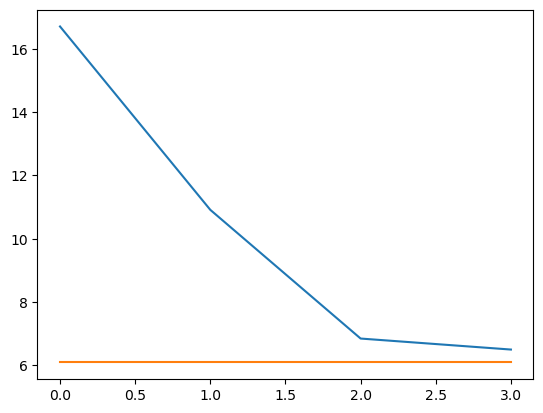

In [113]:
plt.plot(clust_los_nums /rareas)
plt.plot(rands_los_nums /rareas)


In [101]:
rands_los_nums / rareas

array([6.09179035, 6.09179035, 6.09179035, 6.09179035])

In [116]:
magcol = "MAG_I"
rcol = "LOGR"
mag_lims = (17, 22.5)
medges = np.linspace(17, 22.5, 6)
medges2 = np.linspace(22.5, 24.5, 4)

mag_slices = [(17, 19), (19, 20), (20, 21), (21, 22), (22, 22.5)]

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]
redges = [-1.5, -0.5, 0., 0.5, 1.0]
rareas = np.array([np.pi*((10**redges[i+1])**2. - (10**redges[i])**2.) for i in np.arange(len(redges)-1)])

# drawing line - of - sight surface number of objects in each bin
ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]))

clust_los_nums = np.histogram(ctab[ii]["LOGR"], bins=redges)[0] / 41 # / nc

ii = ((refpixel["mag_i"] > mag_lims[0]) & (refpixel["mag_i"] < mag_lims[1]))
surfdens = len(refpixel[ii]) / hp.nside2pixarea(32, degrees=True) / 3600 / 3
rands_los_nums = surfdens * rareas

clust_los_nums[-1] = 6.5 * rareas[-1] # WARNING, this is a hack!!!!!
frac = 1. / (clust_los_nums / rands_los_nums)
fac = 1
clust_nums_to_draw = clust_los_nums * (1 - frac) * fac

print(clust_nums_to_draw)
maglim_max1 = 22.5
maglim_max2 = 24.5
clust_gals = []
field_gals = []
for rbin, r_lims in enumerate(r_lims_all[:4]):
    print(rbin, r_lims)

    #######################################
    sample = csamples[rbin]

    ii = ((ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    vals = np.histogram(ctab[ii][magcol], bins=medges)[0]
    vals = vals / vals.sum()

    for i in np.arange(len(medges) - 1):
        _n_to_draw = clust_nums_to_draw[rbin] * vals[i]
        n_to_draw = np.random.poisson(_n_to_draw)

        index = ((sample[magcol] > medges[i]) & (sample[magcol] < medges[i + 1]) &
                 (sample[rcol] > r_lims[0]) & (sample[rcol] < r_lims[1])).values.astype(bool)
        ii = np.random.randint(0, len(sample.iloc[index]), size=n_to_draw)
        tmp = sample.iloc[index].iloc[ii]
        if len(tmp):
            clust_gals.append(tmp)   

    ii = ((sample[magcol] > mag_lims[0]) & (sample[magcol] < maglim_max1) &
          (sample[rcol] > r_lims[0]) & (sample[rcol] < r_lims[1]))
    num1 = len(sample[ii])

    ii = ((sample[magcol] > maglim_max1) & (sample[magcol] < maglim_max2) &
          (sample[rcol] > r_lims[0]) & (sample[rcol] < r_lims[1]))
    num2 = len(sample[ii])
    fac_clust = num2 / num1

    vals = np.histogram(sample[magcol], bins=medges2)[0]
    vals = vals / vals.sum()
    for i in np.arange(len(medges2) - 1):
        _n_to_draw = clust_nums_to_draw[rbin] * vals[i] * fac_clust
        n_to_draw = np.random.poisson(_n_to_draw)

        index = ((sample[magcol] > medges2[i]) & (sample[magcol] < medges2[i + 1]) &
        (sample[rcol] > r_lims[0]) & (sample[rcol] < r_lims[1])).values.astype(bool)
        ii = np.random.randint(0, len(sample.iloc[index]), size=n_to_draw)
        tmp = sample.iloc[index].iloc[ii]
        if len(tmp):
            clust_gals.append(tmp)   



gals = pd.concat(clust_gals, sort=True)
gals["Z"] = 0.325


[  3.30046749  13.62952712  21.36844189 115.41856032]
0 (-1.5, -0.5)
1 (-0.5, 0.0)
2 (0, 0.5)
3 (0.5, 1.0)


## then the ICL

In [55]:
galpath = "../galsim/ICL/evolving_red_gal.dat"
mstarpath = "../galsim/ICL/mstar_des_i03.fit"
jk_profile_root = "../galsim/ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": -0.1356766444194723,
    "g2":0.0345231539560347,
    "imag": 17.76,
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45
z = 0.3

In [56]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
ims_icl = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/icl.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((arr - pos) * k))


0.05216500535607338


Text(0, 0.5, 'Y [pix]')

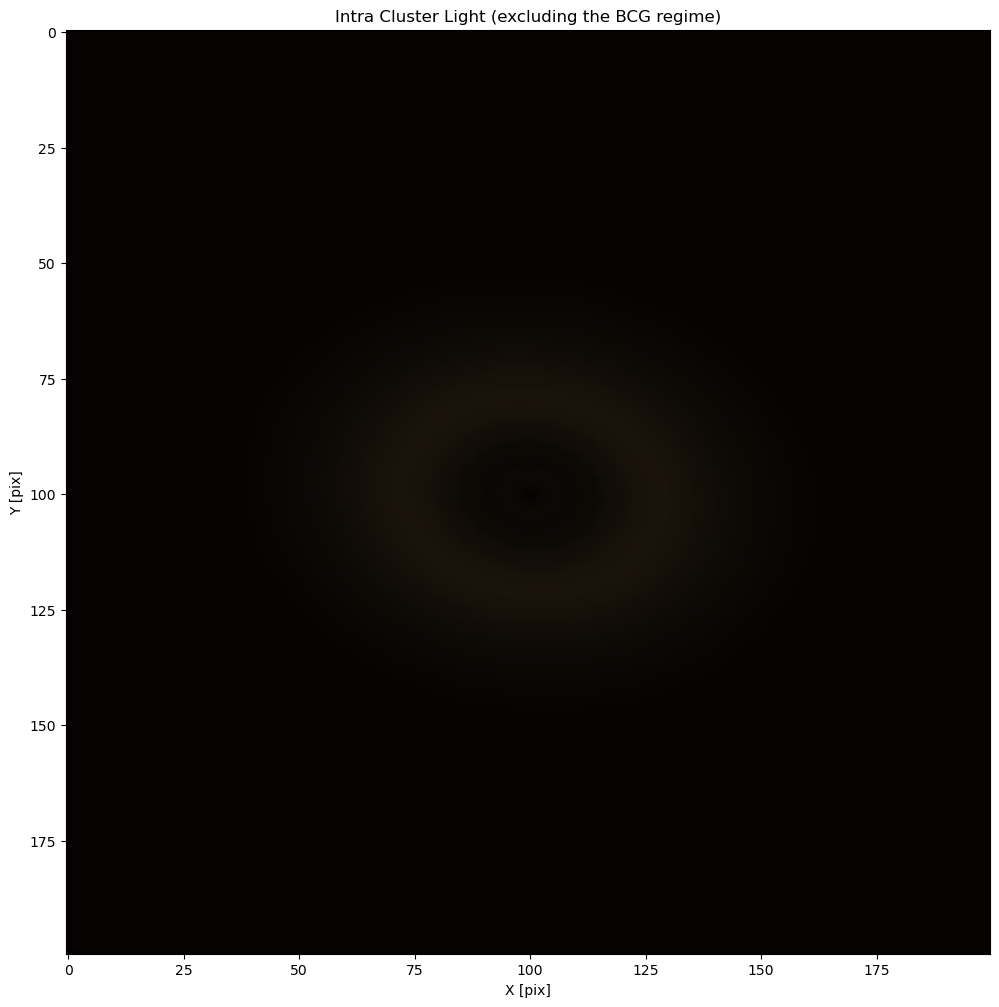

In [59]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_icl[2]+ pad,
                                ims_icl[1]+ pad,
                                ims_icl[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin="upper")
ax.set_title("Intra Cluster Light (excluding the BCG regime)")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

## Then sa